# 動的計画法でCMDPを解く

参考：
* [Approximate Constrained Discounted Dynamic Programming with Uniform Feasibility and Optimality](https://arxiv.org/abs/2308.03297)：今回のやつ．Markovianな方策かつStationary．
* [Dynamic programming equations for discounted constrained stochastic control](https://ieeexplore.ieee.org/abstract/document/1298995)：基本の論文だけど履歴依存＆non-stationary
* [Non-randomized control of constrained Markov decision processes](https://ieeexplore.ieee.org/document/1656446)：基本の論文だけどnon-stationary

基本的にはCMDPはラグランジュ形式や線形計画法で解きます．
しかし，ラグランジュ形式は不安定な問題があったり，線形計画法は高次元な問題に使えにくかったり，それぞれに問題があります．
一方で，CMDPを動的計画法で解こうとする試みはいくつかあります．実装はほぼ不可能？ですが，理論としては面白いです．見てみましょう．

表記：
* 方策 $\pi$：状態$X$から行動$A$へのマップ．決定的な行動と同じ．
* 遷移確率：$P_{x y}^{\pi(x)}$
* 報酬，コスト：$R(x, \pi(x))$，$C(x, \pi(x))$
* 累積報酬，累積コスト：

$$
\begin{aligned}
& V^\pi(x)=E\left[\sum_{t=0}^{\infty} \gamma^t R\left(X_t, \pi\left(X_t\right)\right) \mid X_0=x\right] \\
& J^\pi(x)=E\left[\sum_{t=0}^{\infty} \beta^t C\left(X_t, \pi\left(X_t\right)\right) \mid X_0=x\right]
\end{aligned}
$$

* 方策 → 方策の集合 へのマップ（$\pi$についてuniformly-feasibleな集合）：$\Phi(\pi)=\left\{g \mid g \in \Pi, J^g \leq J^\pi\right\}, \pi \in \Pi$
    * $g \in \Phi(\pi)$のとき，$g$は$\pi$-feasibleと呼ぶ．

今回の特別な表記ですが，$x \in X, \pi \in \Pi$について，最適価値関数を次のように定義します：

$$
V_c^*(x, \pi)=\max _{g \in \Phi(\pi)} V^g(x)
$$

これは何らかの方策$\pi$について定義されてることに注意しましょう！普通は状態についてだけ定義されますが，CMDPの関係上，$\pi$についても引数を取ります．

---

**問題設定の目標**

MDPを$M_{\pi^c}^c\left(x_0\right)=\left(X, A, P, R, C, \pi^c, x_0\right)$として定義します．
ここで，$\pi^c\in \Pi$はthreshold用の方策とします．
今回の目標は，

$$
V_c^*\left(x_0, \pi^c\right)=V^{\pi_c^*}\left(x_0\right)
$$

であるような，$\pi^*_c \in \Phi(\pi^c)$を見つけることとします．
つまり，$\pi^*_c$は$\pi^c$と同じもしくはそれ以下のコストを実現する方策のうち，最大のリターンを達成する方策ですね．

これは$x_0$が固定であり，かつ$\Phi(\pi^c)$が常に空ではないので，$\pi^*_c$は必ず存在します．

---

普通のCMDPでは次の問題を解くことに注意しましょう．ここで$\delta$は初期状態分布です：

$$
\underset{\pi \in \Phi_\delta\left(\pi^c\right)}{\arg \max }\left(\sum_{x \in X} \delta(x) V^\pi(x)\right)
$$

$$
\Phi_\delta\left(\pi^c\right)=\left\{g \mid g \in \Pi, \sum_{x \in X} \delta(x) J^g(x) \leq \sum_{x \in X} \delta(x) J^{\pi^c}(x)\right\}
$$

しかし，これは実はNP困難になります（non-randomizedのときだけ？要検証．[Constrained Discounted Dynamic Programming](https://www.researchgate.net/publication/2656018_Constrained_Discounted_Dynamic_Programming)参照）．

以下，$M_{\pi^c}^c\left(x_0\right)=\left(X, A, P, R, C, \pi^c, x_0\right)$を解くことを考えましょう．


## $M_{\pi^c}^c\left(x_0\right)=\left(X, A, P, R, C, \pi^c, x_0\right)$を解く

$\pi\in \Pi$について，$T_\pi: B(X) \rightarrow B(X)$ および $U_\pi: B(X) \rightarrow B(X)$を次のように定義します：

* 報酬についてのベルマン作用素：$T_\pi(u)(x)=R(x, \pi(x))+\gamma \sum_{y \in X} P_{x y}^{\pi(x)} u(y)$
* コストについてのベルマン作用素：$U_\pi(u)(x)=C(x, \pi(x))+\beta \sum_{y \in X} P_{x y}^{\pi(x)} u(y)$

また，
* $A^\pi$を空でない$A$の部分集合とし，任意の$x\in X$について，$\pi(x)\in A^\pi(x)$および$A^\pi(x) \subseteq A(x)$とする．つまり，$x$で取れる行動の集合のうち，$\pi(x)$が取る行動を含む部分集合です．
* $F: \Pi \to 2^\Pi$：$\pi \in \Pi$について，$F(\pi)=\left\{g \mid g \in \Pi, g(x) \in A^\pi(x) \forall x \in X\right\}$とする．つまり，方策の出力が$A^\pi$に含まれるような方策の集合です．
    * $F(\pi)$が$\Phi(\pi)$の部分集合の時，つまり$F(\pi)$に含まれる方策が$\pi$を使って表現された制約を満たす時，$F(\pi)$は「$A^\pi$によって誘導された$\pi$-feasibleな方策の集合」と呼びます．
    * もし全ての$\pi\in \Pi$について，$A^\pi$が$\pi$-feasibleな方策の集合を誘導する場合，$\left\{A^\pi, \pi \in \Pi\right\}$を「DPに誘導可能な集合」と呼びます．

例えば$x\in X$と$\pi \in \Pi$について，

$$
A^\pi(x)=\left\{a \mid a \in A(x), C(x, a)+\beta \sum_{y \in X} P_{x y}^a J^\pi(y) \leq J^\pi(x)\right\}
$$

とすれば，任意の$\phi \in F(\pi)$について$U_\phi(J^\pi) \leq J^\pi$なので，$J^\phi \leq J^\pi$です．
つまりDP-inducibleな$\{A^\pi, \pi\in \Pi\}$では，$x\in X$と$\pi$について，「$x$からその後$\pi$に従って動いたときに，制約が満たされるような最初の行動の集合」が与えられます．

以下，このようなDP-inducibleな集合$\left\{A^\pi, \pi \in \Pi\right\}$がアクセス可能であると仮定して話を進めます．（つまり，二ステップ目以降に各$\pi$について動くとした時，最初のステップで取って良い行動のリストが分かっている状況）

次の一様最適な価値関数を定義します：

$$
V^*(x, \pi)=\max _{g \in F(\pi)} V^g(x)
$$

$F(\pi)$の中身は制約を満たすので，これは制約を満たす中でReturnを最大にする方策を見つけるのと他なりません．
実際，次の定理が成立します．

---

任意の$\pi \in \Pi$について，$V^*(x, \pi)=V^{\pi^*}(x)$が任意の$x\in X$について成立するような，一様に最適な$\pi$-feasibleな$\pi^*\in F(\pi)$が存在する．

**証明**

適当な$\pi \in \Pi$について，$\left(X, A^\pi, P, R\right)$なる非制約付きMDPを考えてみましょう．
$F(\pi)=\left\{g \mid g \in \Pi, g(x) \in A^\pi(x) \forall x \in X\right\}$は方策の出力が$A^\pi$に含まれる方策の集合なので，このMDPの最適方策は当然$F(\pi)$に入っています．

ここで，$u \in B(X \times \Pi)$について，次の作用素$T_F: B(X \times \Pi) \rightarrow B(X \times \Pi)$を定義します：

$$
T_F(u)(x, \pi)=\max _{g \in F(\pi)}\left(R(x, g(x))+\gamma \sum_{y \in X} P_{x y}^{g(x)} u(y, g)\right)
$$

まず，これは$\gamma$-contractionです．
実際，

$$
\begin{aligned}
& \left\|T_F(u)-T_F(v)\right\|_{\infty} \\
& \quad \leq \max _{x \in X} \max _{\pi \in \Pi} \max _{g \in F(\pi)}\left(\gamma \sum_{y \in X} P_{x y}^{g(x)}|u(y, g)-v(y, g)|\right) \\
& \quad \leq \gamma\|u-v\|_{\infty}
\end{aligned}
$$

です．よって，バナッハの不動点定理から，$T_F(u)=u$となる不動点が存在します．
実はこの不動点は$T_F\left(V^*\right)=V^*$を満たします．

まず，

$$
\begin{aligned}
& V^*(x, \pi)=\max _{g \in F(\pi)} V^g(x) \text { by the definition of } V^* \\
& \quad=\max _{g \in F(\pi)}\left(R(x, g(x))+\gamma \sum_{y \in X} P_{x y}^{g(x)} V^g(y)\right) \text { by the definition of } V^g \\
& \quad \leq \max _{g \in F(\pi)}\left(R(x, g(x))+\gamma \sum_{y \in X} P_{x y}^{g(x)} \max _{\sigma \in F(g)} V^\sigma(y)\right) \text { because } g \in F(g) \\
& \quad=\max _{g \in F(\pi)}\left(R(x, g(x))+\gamma \sum_{y \in X} P_{x y}^{g(x)} V^*(y, g)\right) \text { by the definition of } V^* \\
& \quad=T_F\left(V^*\right)(x, \pi)
\end{aligned}
$$

です．
一方で，$\pi^* \in F(\pi)$ such that $V^*(y, \pi)=V^{\pi^*}(y)$となる$\pi^*$が存在するので，

$$
\begin{aligned}
V^* & (x, \pi)=V^{\pi^*}(x) \\
& =R\left(x, \pi^*(x)\right)+\gamma \sum_{y \in X} P_{x y}^{\pi^*(x)} V^{\pi^*}(y) \\
& =\max _{g \in F(\pi)}\left(R(x, g(x))+\gamma \sum_{y \in X} P_{x y}^{g(x)} V^{\pi^*}(y)\right) \text { by } T_F\left(V^*\right)=V^* \text { and the property of } \pi^* \\
& \geq R(x, \sigma(x))+\gamma \sum_{y \in X} P_{x y}^{\sigma(x)} V^{\pi^*}(y) \text { for any } \sigma \in F(\pi) \\
& =R(x, \sigma(x))+\gamma \sum_{y \in X} P_{x y}^{\sigma(x)} V^*(y, \pi) \text { by the property of } \pi^* \\
& \geq R(x, \sigma(x))+\gamma \sum_{y \in X} P_{x y}^{\sigma(x)} V^*(y, \sigma) \text { because } \sigma \in F(\pi)
\end{aligned}
$$

が成立します．よって不動点は$V^*$です．


---


この作用素をよく見てみましょう．作用素に代入する価値関数は$x$と$\pi$についての関数であることに注意が必要です．
また，ここで$pi$がrandomizedな場合，テーブル形式のDPは実装が難しいですね．（無限次元のテーブルを用意する必要があります．）

簡単な例を使って，この作用素を確認してみましょう．
[Dynamic programming equations for discounted constrained stochastic control](https://ieeexplore.ieee.org/abstract/document/1298995)のExampleを使って見てみます．

* 状態空間：$X=\{0, 1\}$
* 行動空間：$A=\{0, 1\}$

とすると，方策は全部で４通りです：
* $x=0, x=1$での行動：$\Pi=\{(0, 0), (0, 1), (1, 0), (1, 1)\}$

なので，価値関数としては$2 \times 4$のテーブルを用意すれば良いことになります．

* 報酬関数（状態０で報酬発生）：
    * $r(0, 0)=1$
    * $r(0, 1)=1$
    * $r(1, 0)=0$
    * $r(1, 1)=0$
* コスト関数（行動１でコスト発生）：
    * $c(0, 0)=0$
    * $c(0, 1)=1$
    * $c(1, 0)=0$
    * $c(1, 1)=1$
* 遷移確率（$q > p$とする．行動１はRepair行動であり，確率$q$で０に戻る）：
    * $P(0|0, 0)=p$
    * $P(1|0, 0)=1-p$
    * $P(0|1, 0)=0$
    * $P(1|1, 0)=1$
    * $P(0|0, 1)=q$
    * $P(1|0, 1)=1-q$
    * $P(0|1, 1)=q$
    * $P(1|1, 1)=1-q$

このとき，それぞれの方策の価値は
* $(0, 0)$（Repair行動を選択しないので，１に行ったらずっと１）：
    * $V(0)=1 + \gamma p + \gamma^2 p^2 + \dots = \frac{1}{1 - \gamma p}$
    * $V(1)=0$
    * $J(0)=J(1)=0$
* $(1, 0)$（１ではRepair行動を選択しないので，１に行ったらずっと１）：
    * $V(0)=1 + \gamma q + \gamma^2 q^2 + \dots = \frac{1}{1 - \gamma q}$
    * $V(1)=0$
    * $J(0)=\frac{1}{1 - \gamma q}$
    * $J(1)=0$
* $(0, 1)$：
    * $V(0)=\frac{1}{1 - \gamma p} + \gamma^2 (1 - p) q + \gamma^4 ((1 - p) q)^2 \dots = \frac{1}{1 - \gamma p} + \frac{1}{1 - \gamma^2 (1 - p)q}$
    * $V(1)=0$
    * $J$は結構ややこしい...（やってみれば分かる）



In [9]:
import numpy as np
import jax.numpy as jnp
import jax
from typing import NamedTuple, Optional


S = 2  # 状態集合のサイズ
A = 2  # 行動集合のサイズ
S_set = jnp.array([0, 1])  # 状態集合
A_set = jnp.array([0, 1])  # 行動集合
PI_set = jnp.array([(a0, a1) for a0 in A_set for a1 in A_set])
gamma = 0.9  # 割引率


rew = jnp.zeros((S, A))
rew = rew.at[1, 0].set(0)
rew = rew.at[1, 1].set(0)
rew = rew.at[0, 0].set(1)
rew = rew.at[0, 1].set(1)


c = 1
cost = jnp.zeros((S, A))
cost = cost.at[0, 1].set(1)
cost = cost.at[1, 1].set(1)
cost = cost.at[0, 0].set(0)
cost = cost.at[1, 0].set(0)


p = 0.4
q = 0.8
P = jnp.zeros((S, A, S))
P = P.at[0, 0, 0].set(p)
P = P.at[0, 0, 1].set(1 - p)
P = P.at[1, 1, 0].set(q)
P = P.at[1, 1, 1].set(1 - q)
P = P.at[0, 1, 0].set(q)
P = P.at[0, 1, 1].set(1 - q)
P = P.at[1, 0, 1].set(1)
P = P.at[1, 0, 0].set(0)
P = P.reshape(S, A, S)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


# 状態集合, 行動集合, 割引率, 報酬行列, 遷移確率行列が準備できたのでMDPのクラスを作ります

class MDP(NamedTuple):
    S_set: jnp.array  # 状態集合
    A_set: jnp.array  # 行動集合
    PI_set: jnp.array  # 方策の集合
    gamma: float  # 割引率
    H: int  # エフェクティブホライゾン
    rew: jnp.array  # 報酬行列
    cost: jnp.array  # コスト行列
    P: jnp.array  # 遷移確率行列

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)


H = int(1 / (1 - gamma))
mdp = MDP(S_set, A_set, PI_set, gamma, H, rew, cost, P)

print("状態数：", mdp.S)
print("行動数：", mdp.A)
print("割引率：", mdp.gamma)
print("ホライゾン：", mdp.H)

状態数： 2
行動数： 2
割引率： 0.9
ホライゾン： 10


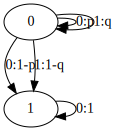

In [8]:
# 状態と遷移の関係．行動は固定されてることに注意

from graphviz import Digraph

g = Digraph('G')

g.node("0")
g.node("1")

g.edge("0", "0", label="0:p")
g.edge("0", "1", label="0:1-p")
g.edge("0", "0", label="1:q")
g.edge("0", "1", label="1:1-q")
g.edge("1", "1", label="0:1")

g

In [12]:
# 疑似コードっぽいのを書きます

import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
import chex


def BellmanBackup(mdp: MDP, V: jnp.array):
    chex.assert_shape(V, (S, S*A))
    # なんかこんな感じ

    for s in mdp.S_set:
        for pi in mdp.PI_set:
            F_pi = compute_F_pi(pi)  # これは多分難しい
            res = []
            for g in F_pi:
                a = g[s]
                res.append(mdp.rew[s, a] + mdp.gamma * mdp.P[s, a] @ V[:, g])
        
            V[s, pi] = max(res)

    return V